In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re
import cdtime
import glob
import fnmatch
import os

pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
import matplotlib.path as mpath
def setup3 ():
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    sbnd = 60.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(figsize=(4, 8)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[10, 1]) 

    ax0 = plt.subplot(gs[0],projection=ccrs.NorthPolarStereo())
    ax0.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
#   ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    
    ax1 = plt.subplot(gs[2],projection=ccrs.NorthPolarStereo())
    ax1.set_global() # make axis consistent with projection limits
    ax1.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.NorthPolarStereo())
    ax2.set_global() # make axis consistent with projection limits
    ax2.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Orthographic(0, 90))
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
#    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
#    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
#   print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
#    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


In [4]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))


def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]

In [5]:
# identify fields to be evaluated

mon = "02"
if 1 == 1:
    # model2 dataset (the experiment)
    dir2 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    files = fnmatch.filter(os.listdir(dir2), "*cam.h1.2009-"+mon+"*00.nc")
#    print "files", files
    
    # the "reference" dataset
    dir1 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    f1 = "yotc_f02_pdil_sat_"+mon+".cam.h0.2009-"+mon+".nc"
    jname1 = dir1+f1
    print "jname1 ", jname1
    
for f2 in files:
    print "f2 is ", f2

jname1  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h0.2009-02.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-14-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-09-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-04-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-07-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-26-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-22-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-21-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-17-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-10-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-27-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-11-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-15-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-19-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-24-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-01-21600.nc
f2 is  yotc_f02_pdil_sat_02.cam.h1.2009-02-20-21600.nc
f2 is  yotc_f02_pdil_

processing time average
reference dataset is jname1 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h0.2009-02.nc
processing timeslice from dir2  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/


/home/d3x345/anaconda2/envs/e3sm-unified-x/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-14-21600.nc
figure being saved to  workdir/TMQ_2009_02_14h06.pdf
data range 0.5183034 20.042223
data range 0.764992 12.871137
data range 0.2565546 2.536486


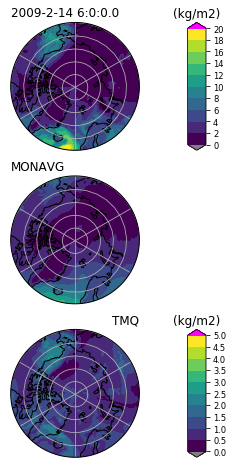

done with time 2009_02_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-09-21600.nc
figure being saved to  workdir/TMQ_2009_02_09h06.pdf
data range 0.41428477 14.496117
data range 0.764992 12.871137
data range 0.18993406 2.6764686


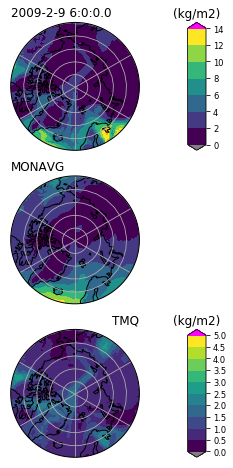

done with time 2009_02_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-04-21600.nc
figure being saved to  workdir/TMQ_2009_02_04h06.pdf
data range 0.42348102 14.523378
data range 0.764992 12.871137
data range 0.19617172 3.7984352


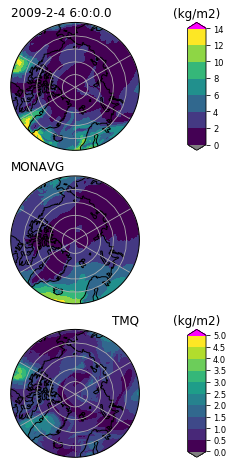

done with time 2009_02_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-07-21600.nc
figure being saved to  workdir/TMQ_2009_02_07h06.pdf
data range 0.62737745 15.387291
data range 0.764992 12.871137
data range 0.20793717 2.4711113


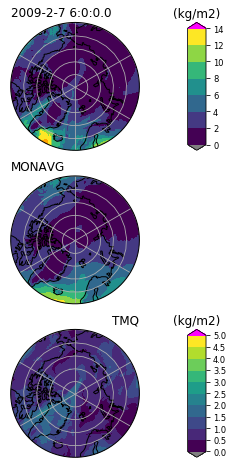

done with time 2009_02_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-26-21600.nc
figure being saved to  workdir/TMQ_2009_02_26h06.pdf
data range 0.3837899 16.356089
data range 0.764992 12.871137
data range 0.13259864 2.5222828


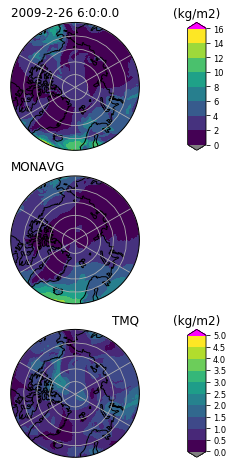

done with time 2009_02_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-22-21600.nc
figure being saved to  workdir/TMQ_2009_02_22h06.pdf
data range 0.19923063 22.404245
data range 0.764992 12.871137
data range 0.16255774 4.080113


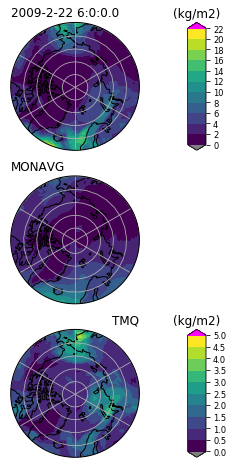

done with time 2009_02_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-21-21600.nc
figure being saved to  workdir/TMQ_2009_02_21h06.pdf
data range 0.19833718 25.858006
data range 0.764992 12.871137
data range 0.104645744 3.0955958


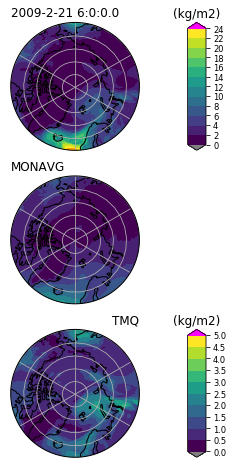

done with time 2009_02_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-17-21600.nc
figure being saved to  workdir/TMQ_2009_02_17h06.pdf
data range 0.34375596 20.022726
data range 0.764992 12.871137
data range 0.15280183 3.7624307


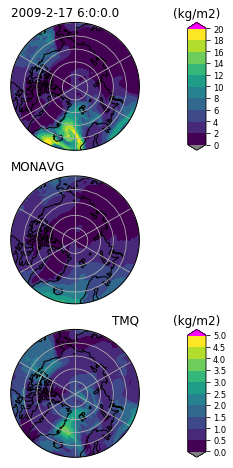

done with time 2009_02_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-10-21600.nc
figure being saved to  workdir/TMQ_2009_02_10h06.pdf
data range 0.4398256 14.162927
data range 0.764992 12.871137
data range 0.15741624 3.0170996


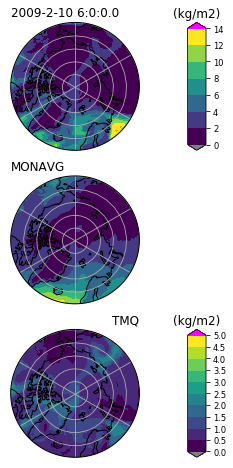

done with time 2009_02_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-27-21600.nc
figure being saved to  workdir/TMQ_2009_02_27h06.pdf
data range 0.4027538 17.307966
data range 0.764992 12.871137
data range 0.13164248 3.8791814


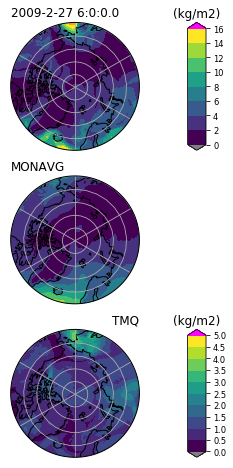

done with time 2009_02_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-11-21600.nc
figure being saved to  workdir/TMQ_2009_02_11h06.pdf
data range 0.4745312 16.156553
data range 0.764992 12.871137
data range 0.25134408 2.6697862


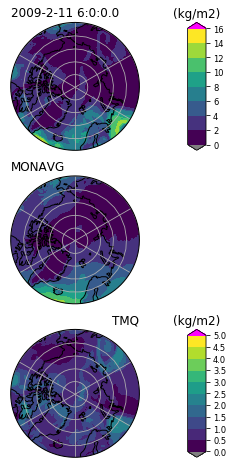

done with time 2009_02_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-15-21600.nc
figure being saved to  workdir/TMQ_2009_02_15h06.pdf
data range 0.5199218 23.280777
data range 0.764992 12.871137
data range 0.28996685 2.724364


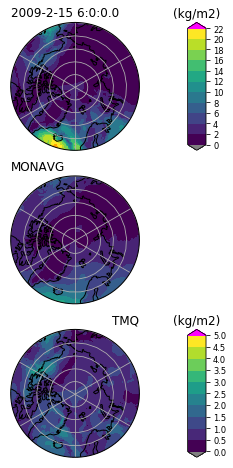

done with time 2009_02_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-19-21600.nc
figure being saved to  workdir/TMQ_2009_02_19h06.pdf
data range 0.35155866 20.487883
data range 0.764992 12.871137
data range 0.17889185 4.5425797


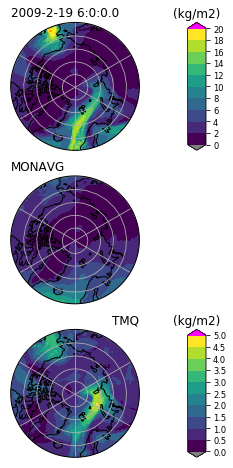

done with time 2009_02_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-24-21600.nc
figure being saved to  workdir/TMQ_2009_02_24h06.pdf
data range 0.35651928 19.226448
data range 0.764992 12.871137
data range 0.24569385 3.7467678


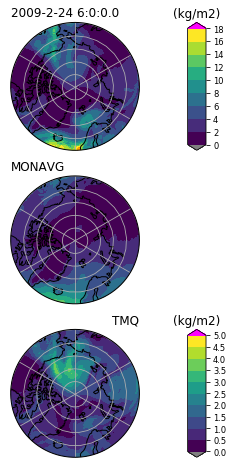

done with time 2009_02_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-01-21600.nc
figure being saved to  workdir/TMQ_2009_02_01h06.pdf
data range 0.3286011 18.324451
data range 0.764992 12.871137
data range 0.2295355 3.4354532


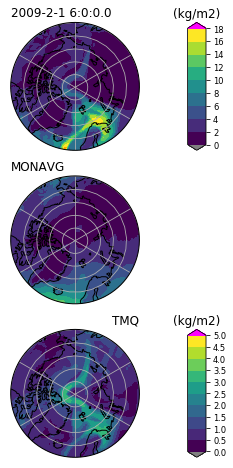

done with time 2009_02_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-20-21600.nc
figure being saved to  workdir/TMQ_2009_02_20h06.pdf
data range 0.28982753 25.956308
data range 0.764992 12.871137
data range 0.22694424 3.8974266


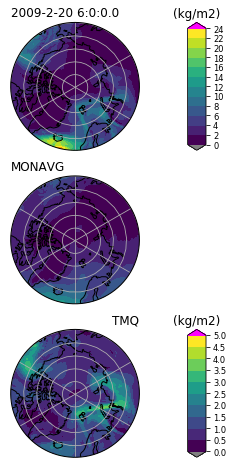

done with time 2009_02_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-06-21600.nc
figure being saved to  workdir/TMQ_2009_02_06h06.pdf
data range 0.5039542 13.171528
data range 0.764992 12.871137
data range 0.16174728 2.8997462


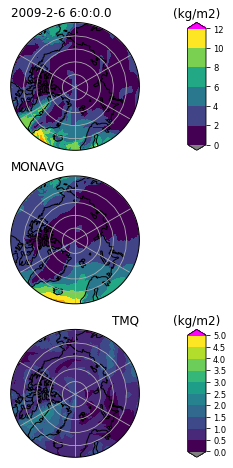

done with time 2009_02_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-28-21600.nc
figure being saved to  workdir/TMQ_2009_02_28h06.pdf
data range 0.42429313 19.051271
data range 0.764992 12.871137
data range 0.22055818 2.8652253


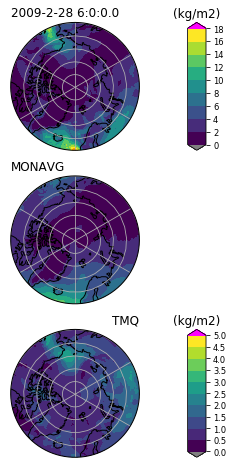

done with time 2009_02_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-13-21600.nc
figure being saved to  workdir/TMQ_2009_02_13h06.pdf
data range 0.42640844 21.364494
data range 0.764992 12.871137
data range 0.21819237 2.8402305


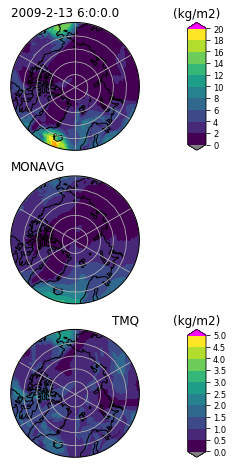

done with time 2009_02_13h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-12-21600.nc
figure being saved to  workdir/TMQ_2009_02_12h06.pdf
data range 0.520616 22.516056
data range 0.764992 12.871137
data range 0.23338422 2.2874496


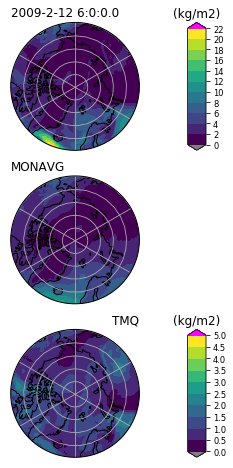

done with time 2009_02_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-08-21600.nc
figure being saved to  workdir/TMQ_2009_02_08h06.pdf
data range 0.4994323 16.550112
data range 0.764992 12.871137
data range 0.20505705 2.5192213


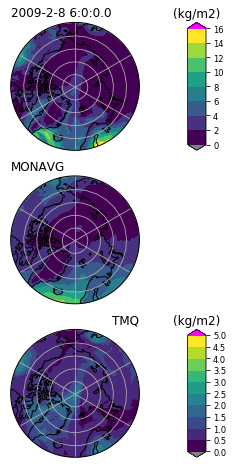

done with time 2009_02_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-25-21600.nc
figure being saved to  workdir/TMQ_2009_02_25h06.pdf
data range 0.31355444 15.76201
data range 0.764992 12.871137
data range 0.2223936 3.098786


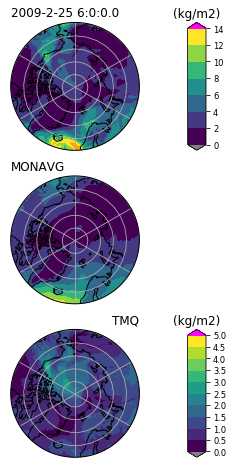

done with time 2009_02_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-03-21600.nc
figure being saved to  workdir/TMQ_2009_02_03h06.pdf
data range 0.2727118 17.621094
data range 0.764992 12.871137
data range 0.18939383 2.3606174


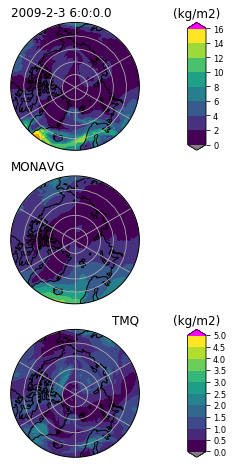

done with time 2009_02_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-05-21600.nc
figure being saved to  workdir/TMQ_2009_02_05h06.pdf
data range 0.45689887 14.797362
data range 0.764992 12.871137
data range 0.104251064 2.9706535


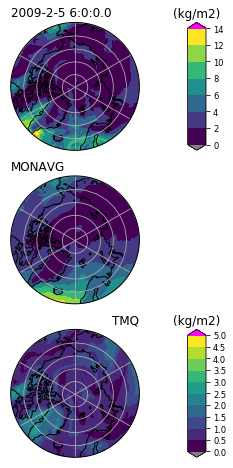

done with time 2009_02_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-18-21600.nc
figure being saved to  workdir/TMQ_2009_02_18h06.pdf
data range 0.17137086 20.89337
data range 0.764992 12.871137
data range 0.07465133 4.57587


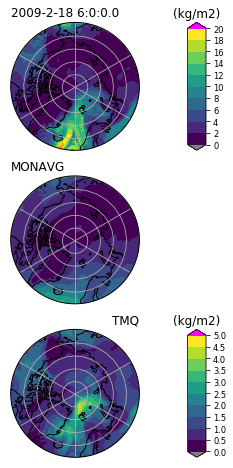

done with time 2009_02_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-23-21600.nc
figure being saved to  workdir/TMQ_2009_02_23h06.pdf
data range 0.2750756 22.87533
data range 0.764992 12.871137
data range 0.22750378 5.3896604


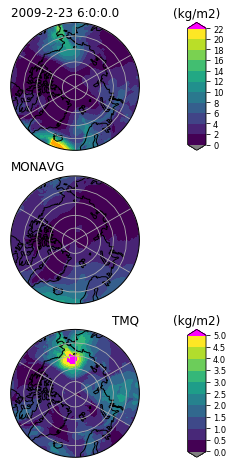

done with time 2009_02_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-16-21600.nc
figure being saved to  workdir/TMQ_2009_02_16h06.pdf
data range 0.45395538 25.644123
data range 0.764992 12.871137
data range 0.16613244 3.1010547


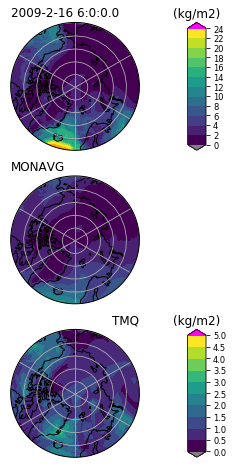

done with time 2009_02_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_02/atm/hist/yotc_f02_pdil_sat_02.cam.h1.2009-02-02-21600.nc
figure being saved to  workdir/TMQ_2009_02_02h06.pdf
data range 0.28272116 14.526479
data range 0.764992 12.871137
data range 0.19870143 2.6486766


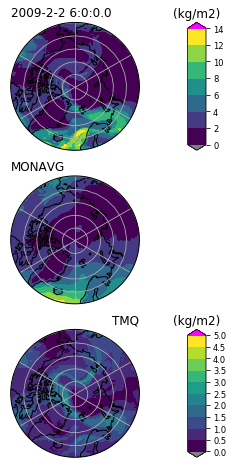

done with time 2009_02_02h06



all done


In [6]:
if 1 == 1:
    


    vname = "BURDEN2"
    vname = "BURDEN1"
    dfact = 0.5  # multiplier on contour levels for anomalies
    vname = "TMQ"
    dfact = 1.0  
    
    print "processing time average"
# model1 dataset (the reference)

    title1 = "MONAVG"
    ltit1 = title1  
    rtit1 = ""
    

    g1 = cdms2.open(jname1);
    print "reference dataset is jname1", jname1  

#    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist2
#    dims2 = g2.listdimension();
#    print "g2 dims", dims2    
    

    T1 = getfld(g1,vname,time=slice(0,1)) # first time slice
#    print "T1 shape", T1.shape

print "processing timeslice from dir2 ", dir2
for f2 in files:
    # model2 dataset (the experiment) 
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2
    varlist = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist
    dims = g2.listdimension();
#   print "j2 dims"
    dims = g2.listdimension();
    tindex = dims.index('time')
#   print "tindex", tindex
    diminfo = g2[dims[tindex]].attributes
    #xx = g2[dims[tindex]].asComponentTime()
    #print "xx",xx
#    print "diminfo", diminfo
    timeunits = diminfo['units']
    #print "timeunits", timeunits
    times = g2[dims[tindex]][:]
    #print "times", times
    starttime = g2[dims[tindex]][0]
    #print "starttime", starttime
    
#if 1 == 1:
    thistime = times[0]
#for thistime in times:
    #print "thistime", thistime

    #T2 = getfld(g2,vname,time=slice(0,1))
    T2 = getfld(g2,vname,time=thistime)
    rt = cdtime.reltime(thistime, timeunits)
    #print "rt", rt
    ct = rt.tocomp()
    #help(ct)
    #print "ct", ct

    title2 = "{:.2f}".format(thistime)
    title2 = ct
    ltit2 = title2
    rtit2 = ""
 
# if 1 == 1:
    sbnd = 60.
    T1 = T1.subRegion(latitude=(sbnd,90.))
    T2 = T2.subRegion(latitude=(sbnd,90.))


#    T2 = getfld(g2,"QV")
#    DELP = getfld(g2,'DELP')
#    T2V = T2*DELP/9.806

#    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
#    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
#    print "range", T2V.min(), T2V.max()
#    pltframe(T2V, lons, lats, ax3[0], cx3[0])    
#    T2 = T2V    

#   DT = T2 - T1
    DT = T2/T1
    DT.id = T1.id

    lonsdt = DT.getLongitude()
    latsdt = DT.getLatitude()

    ctstring = "{:04d}_{:02d}_{:02d}h{:02d}".format(ct.year, ct.month, ct.day, ct.hour)
    pltname = "workdir/"+vname+"_"+ctstring+".pdf"
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
    #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    print "figure being saved to ", pltname
    fig, ax3, cx3 = setup3()
#    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
    #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    


    cmap = plt.cm.viridis

#    print "plotting MERRA2"
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    print "plotting E3SM"
    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    cmap = pjr.diverge_map()
    cmap = plt.cm.viridis
    
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

#    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
    dtitle = ""
    rtitD = vname
    pltframe(DT, lonsdt, latsdt, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

    
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    x = plt.show()

    print "done with time "+ctstring+"\n\n\n"


print "all done"